In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import ast

# --------------------------------------------------------------------------------
# CONFIGURATION & PATHS
# --------------------------------------------------------------------------------
LONG_PCT = 0.1
SHORT_PCT = 0.1
LEVERAGE = 1.0
HOLDING_WEEKS = 1
equal_weight = False  # Set to True for equal-weighted portfolio
# Input Paths
SENTIMENT_2022 = "../data/daily_absa_2022.csv"
SENTIMENT_2024 = "../data/daily_absa_2024.csv"

MOM_PATH = "../data/weekly_momentum.csv"
SENTIMENT_paths = ["../data/combined_news_weighted_softmax.csv"]
SP500_MAPPING = "../data/sp_500_constituents.xlsx"
STOCK_RET_PATH = 'momentum/s&p500ret.csv' 
SP500_RET_PATH = "../data/snp500_ret.csv"    # Path to index returns

# --------------------------------------------------------------------------------
# 1. DATA LOADING & ENTITY MATCHING
# --------------------------------------------------------------------------------

def load_raw_sentiment() -> pd.DataFrame:
    """
    Loads and concatenates daily sentiment files.
    """
    dfs = []
    for path in SENTIMENT_paths:
        if os.path.exists(path):
            print(f"Loading sentiment: {path}")
            df = pd.read_csv(path)
            dfs.append(df)
        else:
            print(f"Warning: File not found {path}")
            
    if not dfs:
        return pd.DataFrame()
        
    combined = pd.concat(dfs, ignore_index=True)
    
    # Basic cleanup
    if 'date' in combined.columns:
        combined['date'] = pd.to_datetime(combined['date'])
    
    return combined

def map_entities_to_tickers(sentiment_df: pd.DataFrame) -> pd.DataFrame:
    """
    Maps sentiment 'entity' names to S&P 500 Tickers.
    """
    if not os.path.exists(SP500_MAPPING):
        print(f"Warning: Mapping file not found at {SP500_MAPPING}")
        return sentiment_df

    sp500 = pd.read_excel(SP500_MAPPING)
    
    # Case 1: Entity is the Ticker (common in financial datasets)
    sentiment_df['TICKER'] = sentiment_df['entity'].str.upper()
    
    # Filter to only include tickers present in our SP500 universe
    valid_tickers = set(sp500['Ticker'].unique())
    mapped_df = sentiment_df[sentiment_df['TICKER'].isin(valid_tickers)].copy()
    
    print(f"Mapped {len(mapped_df)} rows to valid S&P 500 tickers.")
    return mapped_df

def parse_sentiment_string(val):
    """
    Parses stringified dict "{'positive': 0.1, ...}" into a float score.
    Score = Prob(Positive) - Prob(Negative)
    """
    if isinstance(val, (int, float)):
        return val
    
    if isinstance(val, str):
        try:
            # Convert string "{...}" to dict
            d = ast.literal_eval(val)
            if isinstance(d, dict):
                pos = d.get('positive', 0)
                neg = d.get('negative', 0)
                return pos - neg
        except (ValueError, SyntaxError):
            return np.nan
    return np.nan

def build_weekly_signal(daily_df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregates daily sentiment to Weekly (Fri-Fri).
    """
    daily_df = daily_df.copy()
    
    # Group by Week Ending Friday
    daily_df['week_date'] = daily_df['date'].dt.to_period('W-FRI').dt.to_timestamp()
    
    # Detect the sentiment column
    target_col = None
    possible_cols = ['softmax', 'sentiment', 'score', 'SENT'] 
    
    for col in possible_cols:
        if col in daily_df.columns:
            target_col = col
            break
            
    if target_col is None:
        print(f"Warning: Sentiment column not found. Available: {daily_df.columns}")
        return pd.DataFrame()

    print(f"Using '{target_col}' as the raw sentiment signal.")

    # Check the first valid value to see if it's a string
    first_valid = daily_df[target_col].dropna().iloc[0] if not daily_df[target_col].dropna().empty else 0
    
    if isinstance(first_valid, str) and '{' in first_valid:
        print(f"Parsing stringified dictionaries in column '{target_col}'...")
        # Apply parsing logic to create a numeric score
        daily_df[target_col] = daily_df[target_col].apply(parse_sentiment_string)

    # Ensure column is numeric now
    daily_df[target_col] = pd.to_numeric(daily_df[target_col], errors='coerce')

    # Aggregate
    weekly_signal = (
        daily_df.groupby(['TICKER', 'week_date'])[target_col]
        .mean()
        .reset_index()
        .rename(columns={target_col: 'SENT'})
    )
    
    return weekly_signal

# --------------------------------------------------------------------------------
# 2. MARKET DATA PREP
# --------------------------------------------------------------------------------

def load_stock_returns(csv_path: str = STOCK_RET_PATH) -> pd.DataFrame:
    """
    Loads daily stock returns and compounds them to weekly.
    """
    if not os.path.exists(csv_path):
        print(f"Warning: Stock returns not found at {csv_path}")
        return pd.DataFrame(columns=['week_date', 'TICKER', 'RET'])

    df = pd.read_csv(csv_path)
    
    # Standardize names
    df.columns = [c.lower() for c in df.columns]
    
    df['date'] = pd.to_datetime(df['date'])
    
    # Handle potential non-numeric returns
    if 'ret' in df.columns:
        df['ret'] = pd.to_numeric(df['ret'], errors='coerce')
    
    # Drop missing returns
    df = df.dropna(subset=['ret'])
    
    # Weekly Aggregation
    df['week_date'] = df['date'].dt.to_period('W-FRI').dt.to_timestamp()
    
    weekly_ret = (
        df.groupby(['ticker', 'week_date'])['ret']
        .apply(lambda x: (1 + x).prod() - 1)
        .reset_index()
        .rename(columns={'ret': 'RET', 'ticker': 'TICKER'})
    )
    
    # Normalize Ticker
    weekly_ret['TICKER'] = weekly_ret['TICKER'].str.upper()
    
    return weekly_ret

def load_sp500_weekly(csv_path: str = SP500_RET_PATH) -> pd.DataFrame:
    """
    Loads S&P 500 index returns for benchmarking.
    """
    try:
        sp = pd.read_csv(csv_path)
        sp = sp.rename(columns={'caldt': 'date', 'sprtrn': 'sp500_ret'})
        sp['date'] = pd.to_datetime(sp['date'])
        sp['sp500_ret'] = pd.to_numeric(sp['sp500_ret'], errors='coerce')
        sp = sp.dropna(subset=['sp500_ret'])
        
        # Week ending Friday (Normalized to Midnight)
        sp['week_date'] = sp['date'].dt.to_period('W-FRI').dt.to_timestamp()

        weekly = (
            sp.groupby('week_date')['sp500_ret']
              .apply(lambda x: (1 + x).prod() - 1)
              .reset_index(name='sp500_ret')
        )
        
        weekly = weekly.sort_values('week_date')
        
        # Align Benchmark: Strategy at T predicts T+1. Benchmark must be T+1.
        weekly['sp500_ret_next'] = weekly['sp500_ret'].shift(-1)
        
        return weekly.dropna()
    except FileNotFoundError:
        print(f"Warning: S&P 500 file not found at {csv_path}.")
        return pd.DataFrame(columns=['week_date', 'sp500_ret', 'sp500_ret_next'])

# --------------------------------------------------------------------------------
# 3. DATA ALIGNMENT 
# --------------------------------------------------------------------------------

def prepare_aligned_data(weekly_signal: pd.DataFrame, weekly_returns: pd.DataFrame) -> pd.DataFrame:
    """
    Merges Signal (Week T) with Returns (Week T+1).
    This is the central point for preventing look-ahead bias.
    """
    # Merge on Ticker and Date
    df = pd.merge(weekly_signal, weekly_returns, on=['TICKER', 'week_date'], how='inner')
    print('df:',df)
    
    # Sort strictly
    df = df.sort_values(['TICKER', 'week_date'])
    
    # ---------------------------------------------------------
    # SHIFT LOGIC:
    # We have Signal_T and Return_T on the same row.
    # We want to trade Signal_T to capture Return_{T+1}.
    # So we create 'RET_next' by shifting 'RET' backward by 1.
    # ---------------------------------------------------------
    df['RET_next'] = df.groupby('TICKER')['RET'].shift(-1)
    
    # Drop the last row (where we have a signal but no future return known yet)
    # df = df.dropna(subset=['RET_next', 'SENT'])
    df = df.dropna(subset=['RET_next', 'MOM_12w'])
    
    return df

# --------------------------------------------------------------------------------
# 4. BACKTEST ENGINE
# --------------------------------------------------------------------------------

def construct_weights(signal_cs: pd.Series,
                      long_pct=LONG_PCT,
                      short_pct=SHORT_PCT,
                      gross_leverage=LEVERAGE, 
                      equal_weight=True) -> pd.Series:
    """
    Calculates long/short weights based on signal ranking.
    """
    sig = signal_cs.dropna()
    if sig.empty:
        return pd.Series(dtype=float)
    
    n = len(sig)
    n_long = max(1, int(round(n * long_pct)))
    n_short = max(1, int(round(n * short_pct)))
    
    ranked = sig.sort_values(ascending=False)
    long_cands = ranked.iloc[:n_long]
    short_cands = ranked.iloc[-n_short:]

    if equal_weight:
        w_long = pd.Series(1.0 / n_long, index=long_cands.index)
        w_short = pd.Series(-1.0 / n_short, index=short_cands.index)
    else:
        # Signal Weighted
        long_denom = long_cands.abs().sum()
        w_long = (long_cands.abs() / long_denom) if long_denom > 0 else pd.Series(1.0/n_long, index=long_cands.index)

        short_denom = short_cands.abs().sum()
        w_short = ((short_cands.abs() / short_denom) * -1) if short_denom > 0 else pd.Series(-1.0/n_short, index=short_cands.index)
        
    w = pd.concat([w_long, w_short])
    
    if w.abs().sum() > 0:
        w *= gross_leverage / w.abs().sum()
            
    return w

def build_weight_panel(df: pd.DataFrame,
                       holding_weeks: int,
                       col_signal: str,
                       equal_weight: bool = False) -> pd.DataFrame:
    print(df[['TICKER', 'week_date']].dtypes)
    all_weeks = sorted(df['week_date'].unique())
    recs = []

    for i, w in enumerate(all_weeks):
        cs_slice = df[df['week_date'] == w]
        # Extract signal
        sig_cs = cs_slice.set_index('TICKER')[col_signal]
        
        w_cs = construct_weights(sig_cs, equal_weight=equal_weight)
        
        if w_cs.empty:
            continue

        # Holding Period Logic
        hold_weeks = all_weeks[i : i + holding_weeks]
        for hw in hold_weeks:
            recs.append(pd.DataFrame({
                'week_date': hw,
                'TICKER': w_cs.index,
                'weight': w_cs.values / holding_weeks
            }))
    print(recs)
    if recs:
        combined = pd.concat(recs, ignore_index=True)
        return combined.groupby(['week_date', 'TICKER'], as_index=False)['weight'].sum()
    else:
        return pd.DataFrame(columns=['week_date', 'TICKER', 'weight'])

def compute_pnl_timeseries(df: pd.DataFrame, weight_panel: pd.DataFrame) -> pd.DataFrame:
    
    # Merge Weights (Time T) with Returns (Time T+1)
    merged = pd.merge(
        weight_panel,
        df[['TICKER', 'week_date', 'RET_next']], 
        on=['TICKER', 'week_date'],
        how='left'
    )
    
    merged['pnl'] = merged['weight'] * merged['RET_next']
    
    def agg_pnl(x):
        long_pnl = x[x['weight'] > 0]['pnl'].sum()
        short_pnl = x[x['weight'] < 0]['pnl'].sum()
        return pd.Series({
            'port_ret_long': long_pnl,
            'port_ret_short': short_pnl,
            'port_ret': long_pnl + short_pnl 
        })

    pnl = merged.groupby('week_date').apply(agg_pnl).reset_index()

    # Universe Benchmark
    benchmark = (
        df.groupby('week_date')['RET_next']
          .mean()
          .rename('benchmark_ret')
          .reset_index()
    )
    
    pnl = pnl.merge(benchmark, on='week_date', how='left')
    pnl['benchmark_ret'] = pnl['benchmark_ret'].fillna(0.0)
    pnl['excess_ret'] = pnl['port_ret'] - pnl['benchmark_ret']

    # S&P 500 Benchmark
    sp500 = load_sp500_weekly()
    if not sp500.empty:
        pnl = pnl.merge(sp500[['week_date', 'sp500_ret_next']], on='week_date', how='left')
        pnl = pnl.rename(columns={'sp500_ret_next': 'sp500_ret'})
        pnl['sp500_ret'] = pnl['sp500_ret'].fillna(0.0)
    else:
        pnl['sp500_ret'] = 0.0

    # Cumulative Value
    pnl['port_value'] = (1 + pnl['port_ret']).cumprod()
    pnl['benchmark_value'] = (1 + pnl['benchmark_ret']).cumprod()
    pnl['sp500_value'] = (1 + pnl['sp500_ret']).cumprod()
    pnl['excess_value'] = (1 + pnl['excess_ret']).cumprod()
    
    return pnl.dropna(subset=['port_ret'])




print("1. Loading Raw Sentiment Data...")
raw_sentiment = load_raw_sentiment()
print("2. Mapping Entities and Aggregating Signals...")
mapped_sentiment = map_entities_to_tickers(raw_sentiment)
# 改成momentum的signal 
# weekly_signal = build_weekly_signal(mapped_sentiment)
weekly_signal = pd.read_csv(MOM_PATH)
weekly_signal["week_date"] = pd.to_datetime(weekly_signal["week_date"])
# weekly_signal['week_date']= weekly_signal['week_date'].dt.to_period('W-FRI').dt.to_timestamp()
weekly_signal["TICKER"] = weekly_signal["TICKER"].astype(str)

print("3. Loading Market Data...")
weekly_returns = load_stock_returns()
# weekly_returns["week_date"] = weekly_returns["week_date"].dt.strftime("%Y-%m-%d")

analysis_df = prepare_aligned_data(weekly_signal, weekly_returns)
print(f"   Data ready. {len(analysis_df)} rows across {analysis_df['week_date'].nunique()} weeks.")

print("5. Running Backtest...")
# col_signal 改成momentum的label 
# weight_panel = build_weight_panel(analysis_df, holding_weeks=HOLDING_WEEKS, col_signal='SENT', equal_weight=equal_weight)
weight_panel = build_weight_panel(analysis_df, holding_weeks=HOLDING_WEEKS, col_signal='MOM_12w', equal_weight=equal_weight)
weekly_perf = compute_pnl_timeseries(analysis_df, weight_panel)


# --- Summary Stats ---
weeks = len(weekly_perf)
port_series = weekly_perf['port_value']
total_ret = (port_series.iloc[-1] - 1) if weeks > 0 else 0

# Annualized Sharpe
avg = weekly_perf['port_ret'].mean()
vol = weekly_perf['port_ret'].std(ddof=1)
sharpe = (avg / vol) * np.sqrt(52) if vol > 0 else np.nan

print("\n" + "="*40)
print(f"BACKTEST RESULTS (Equal Weight: {equal_weight})")
print("="*40)
print(f"Total Return:    {total_ret:.2%}")
print(f"Sharpe Ratio:    {sharpe:.2f}")
print(f"Weeks Traded:    {weeks}")
print(f"Start Date:      {weekly_perf['week_date'].min().date()}")
print(f"End Date:        {weekly_perf['week_date'].max().date()}")


1. Loading Raw Sentiment Data...
Loading sentiment: ../data/combined_news_weighted_softmax.csv
2. Mapping Entities and Aggregating Signals...
Mapped 254397 rows to valid S&P 500 tickers.
3. Loading Market Data...


/var/folders/pv/7p_t7rb926b5n_ct8w7y94v80000gn/T/ipykernel_76817/3779975053.py:150: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


df:        TICKER  week_date   MOM_12w       RET
0        ORCL 2020-01-04 -0.001008  0.017325
1        ORCL 2020-01-11 -0.027753  0.012489
2        ORCL 2020-01-18 -0.007973 -0.019227
3        ORCL 2020-01-25  0.026091 -0.029960
4        ORCL 2020-02-01  0.013466  0.043279
...       ...        ...       ...       ...
120209   TSLA 2024-11-30  0.646502  0.127652
120210   TSLA 2024-12-07  0.446280  0.120779
120211   TSLA 2024-12-14  0.607809 -0.034774
120212   TSLA 2024-12-21  0.714087  0.025175
120213   TSLA 2024-12-28  0.715720 -0.064449

[120214 rows x 4 columns]
   Data ready. 119700 rows across 260 weeks.
5. Running Backtest...
TICKER               object
week_date    datetime64[ns]
dtype: object
[    week_date TICKER    weight
0  2020-01-04   TSLA  0.025648
1  2020-01-04   QRVO  0.018564
2  2020-01-04   SWKS  0.017805
3  2020-01-04   ALGN  0.015280
4  2020-01-04    CZR  0.015173
..        ...    ...       ...
85 2020-01-04    PSA -0.020483
86 2020-01-04   EXPE -0.027724
87 2020-01-

/var/folders/pv/7p_t7rb926b5n_ct8w7y94v80000gn/T/ipykernel_76817/3779975053.py:335: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pnl = merged.groupby('week_date').apply(agg_pnl).reset_index()


In [54]:
weekly_returns

,TICKER,week_date,RET
0,A,2018-12-29,-0.029647
1,A,2019-01-05,0.075160
2,A,2019-01-12,0.022024
3,A,2019-01-19,0.023913
4,A,2019-01-26,0.032450
...,...,...,...
153533,ZTS,2024-11-30,0.006905
153534,ZTS,2024-12-07,0.009747
153535,ZTS,2024-12-14,-0.074868
153536,ZTS,2024-12-21,-0.001455


In [55]:
# weekly_signal = build_weekly_signal(mapped_sentiment)
print("weekly_signal:")
print(weekly_signal[['TICKER', 'week_date']].dtypes)

print("\nweekly_returns:")
print(weekly_returns[['TICKER', 'week_date']].dtypes)

weekly_signal:
TICKER               object
week_date    datetime64[ns]
dtype: object

weekly_returns:
TICKER               object
week_date    datetime64[ns]
dtype: object


In [ ]:
weekly_signal.to_csv('../data/weekly_sentiment_momentum.csv', index=False) 


In [ ]:
weight_panel['weight']

,week_date,TICKER,weight
0,2018-12-29,BA,0.050212
1,2018-12-29,CAG,-0.046569
2,2018-12-29,CHTR,0.050211
3,2018-12-29,DLTR,0.049595
4,2018-12-29,EA,-0.050472
...,...,...,...
12219,2024-12-21,TSCO,0.025992
12220,2024-12-21,UNH,0.023823
12221,2024-12-21,VRSN,-0.028854
12222,2024-12-21,WAT,-0.010336


In [132]:
df = pd.read_csv('../data/guardian_scores.csv')
df['entity'].nunique()

361

In [169]:
test = weight_panel[weight_panel['week_date'] == '2024-08-03']

test[test['weight'] > 0 ]['weight'].sum()

np.float64(0.5000000000000001)

In [141]:
weekly_signal[weekly_signal['week_date'] == '2024-08-03'].shape

(274, 3)

In [195]:
(weekly_perf['sp500_ret'].mean())/weekly_perf['sp500_ret'].std(ddof=1) * np.sqrt(52)

np.float64(0.8396924516447714)

In [ ]:
(weekly_perf['port_ret'].mean())/weekly_perf['port_ret'].std(ddof=1) * np.sqrt(52)

np.float64(0.35933699917294226)

In [137]:
import statsmodels.api as sm 
X = sm.add_constant(weekly_perf['sp500_ret'])
y = weekly_perf['port_ret'] 
model = sm.OLS(y, X).fit() 
print(model.summary()) 

                            OLS Regression Results                            
Dep. Variable:               port_ret   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     18.85
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           1.92e-05
Time:                        14:32:33   Log-Likelihood:                 964.41
No. Observations:                 313   AIC:                            -1925.
Df Residuals:                     311   BIC:                            -1917.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      4.574      0.0

In [163]:
weekly_perf['port_value']

0      1.017576
1      1.028409
2      1.027602
3      0.994412
4      1.000491
         ...   
308    2.142282
309    2.147287
310    2.200451
311    2.192864
312    2.195969
Name: port_value, Length: 313, dtype: float64

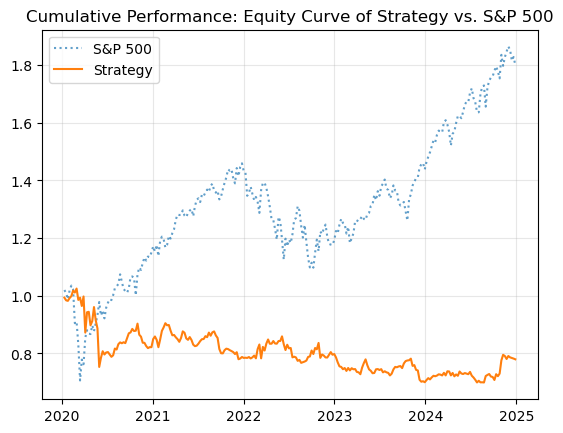

In [56]:
plot_dates = weekly_perf['week_date'] + pd.Timedelta(weeks=1)
plt.plot(plot_dates, weekly_perf['sp500_value'], label='S&P 500', linestyle=':', alpha=0.7)
plt.plot(plot_dates, weekly_perf['port_value'], label='Strategy')
plt.title(f"Cumulative Performance: Equity Curve of Strategy vs. S&P 500")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


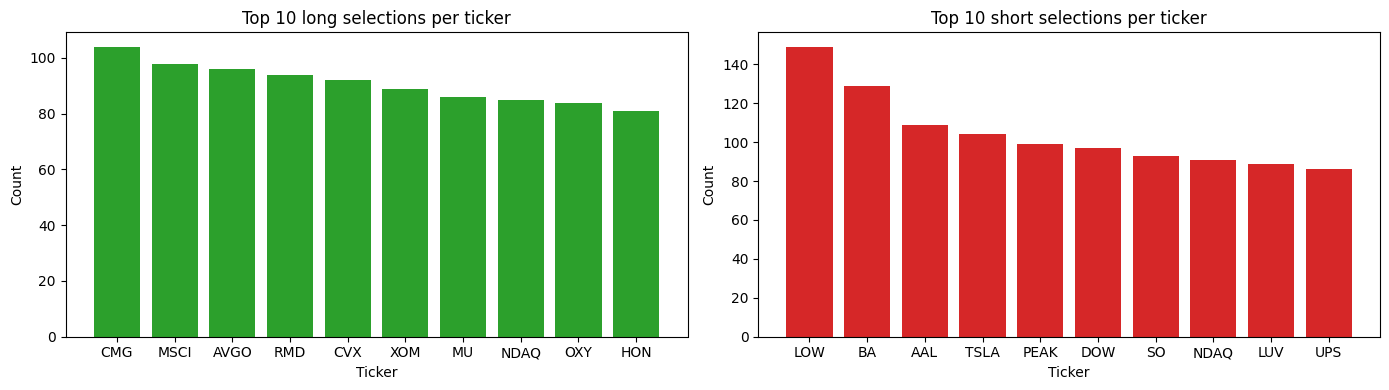

In [89]:
# Histogram: selection frequency by ticker
import matplotlib.pyplot as plt

weights = weight_panel.copy()
long_counts = (
    weights[weights['weight'] > 0]
        .groupby('TICKER')
        .size()
        .rename('long_count')
)
short_counts = (
    weights[weights['weight'] < 0]
        .groupby('TICKER')
        .size()
        .rename('short_count')
)
selection_counts = (
    pd.concat([long_counts, short_counts], axis=1)
      .fillna(0)
      .sort_values('long_count', ascending=False)
)
selection_counts.head(10)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
top_long = long_counts.sort_values(ascending=False).head(10)
top_short = short_counts.sort_values(ascending=False).head(10)
axes[0].bar(top_long.index, top_long.values, color='tab:green')
axes[0].set_title('Top 10 long selections per ticker')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Ticker')

axes[1].bar(top_short.index, top_short.values, color='tab:red')
axes[1].set_title('Top 10 short selections per ticker')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Ticker')

plt.tight_layout()


In [191]:
long_counts['TSLA']

np.int64(50)

--- Starting Sentiment vs. Momentum Analysis ---
Loading: ../data/combined_equal_softmax.csv


/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_31472/3417086878.py:67: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


Calculating Momentum (52-week lookback, 1-week lag)...
Aligned Observations: 56344
------------------------------
Pearson corr (Sentiment vs. Momentum): 0.0844
Spearman rank corr: 0.1120
Rank-corr t-stat:   26.75 (n=56344)
------------------------------


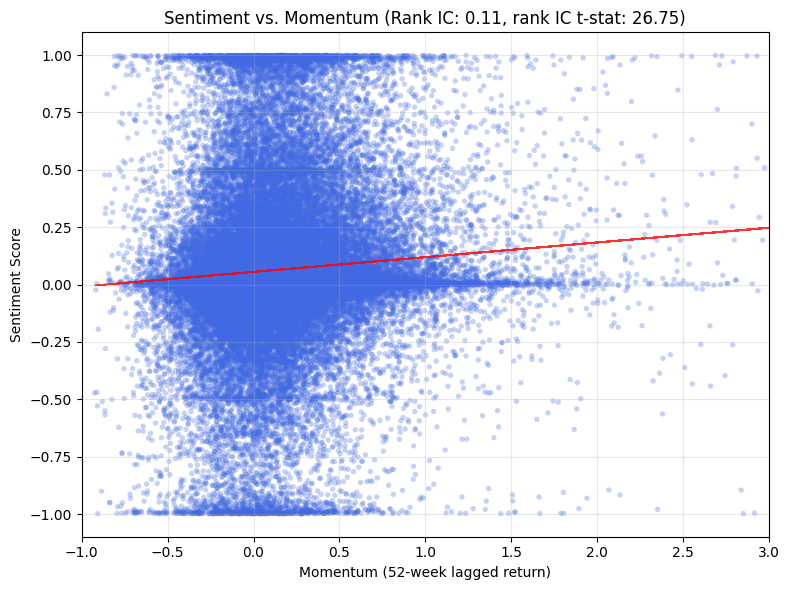


Sample Data:
  TICKER  week_date      SENT       MOM
0      A 2020-09-12  0.073390  0.276911
1      A 2020-11-14  0.533252  0.419619
2      A 2020-12-05  0.015987  0.412497
3      A 2021-01-09  0.014814  0.462153
4      A 2021-01-30  0.028092  0.467116


In [321]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import ast

# --------------------------------------------------------------------------------
# CONFIGURATION & PATHS
# --------------------------------------------------------------------------------
LOOKBACK_WEEKS = 52 
SP500_MAPPING = "../data/sp_500_constituents.xlsx"
STOCK_RET_PATH = "momentum/s&p500ret.csv"

# --------------------------------------------------------------------------------
# 1. DATA LOADING HELPER FUNCTIONS (Reused)
# --------------------------------------------------------------------------------

def load_raw_sentiment() -> pd.DataFrame:
    dfs = []
    for path in SENTIMENT_paths:
        if os.path.exists(path):
            print(f"Loading: {path}")
            dfs.append(pd.read_csv(path))
    
    if not dfs: return pd.DataFrame()
    combined = pd.concat(dfs, ignore_index=True)
    if 'date' in combined.columns:
        combined['date'] = pd.to_datetime(combined['date'])
    return combined

def map_entities_to_tickers(sentiment_df: pd.DataFrame) -> pd.DataFrame:
    if not os.path.exists(SP500_MAPPING):
        return sentiment_df
    sp500 = pd.read_excel(SP500_MAPPING)
    sentiment_df['TICKER'] = sentiment_df['entity'].str.upper()
    valid_tickers = set(sp500['Ticker'].unique())
    return sentiment_df[sentiment_df['TICKER'].isin(valid_tickers)].copy()

def parse_sentiment_string(val):
    if isinstance(val, (int, float)): return val
    if isinstance(val, str):
        try:
            d = ast.literal_eval(val)
            if isinstance(d, dict):
                return d.get('positive', 0) - d.get('negative', 0)
        except: return np.nan
    return np.nan

def build_weekly_signal(daily_df: pd.DataFrame) -> pd.DataFrame:
    daily_df = daily_df.copy()
    daily_df['week_date'] = daily_df['date'].dt.to_period('W-FRI').dt.to_timestamp()
    
    target_col = next((c for c in ['softmax', 'sentiment', 'score', 'SENT'] if c in daily_df.columns), None)
    if not target_col: return pd.DataFrame()

    first_valid = daily_df[target_col].dropna().iloc[0] if not daily_df[target_col].dropna().empty else 0
    if isinstance(first_valid, str) and '{' in first_valid:
        daily_df[target_col] = daily_df[target_col].apply(parse_sentiment_string)
    
    daily_df[target_col] = pd.to_numeric(daily_df[target_col], errors='coerce')
    
    return (daily_df.groupby(['TICKER', 'week_date'])[target_col]
            .mean().reset_index().rename(columns={target_col: 'SENT'}))

def load_stock_returns(csv_path: str) -> pd.DataFrame:
    if not os.path.exists(csv_path): return pd.DataFrame()
    df = pd.read_csv(csv_path)
    df.columns = [c.lower() for c in df.columns]
    df['date'] = pd.to_datetime(df['date'])
    df['ret'] = pd.to_numeric(df['ret'], errors='coerce')
    df = df.dropna(subset=['ret'])
    
    df['week_date'] = df['date'].dt.to_period('W-FRI').dt.to_timestamp()
    weekly_ret = (df.groupby(['ticker', 'week_date'])['ret']
                  .apply(lambda x: (1 + x).prod() - 1)
                  .reset_index().rename(columns={'ret': 'RET', 'ticker': 'TICKER'}))
    weekly_ret['TICKER'] = weekly_ret['TICKER'].str.upper()
    return weekly_ret

# --------------------------------------------------------------------------------
# 2. MOMENTUM CALCULATION
# --------------------------------------------------------------------------------

def compute_momentum(weekly_returns: pd.DataFrame, lookback_weeks: int) -> pd.DataFrame:
    """
    Calculates Momentum: Cumulative return over 'lookback_weeks', lagged by 1 week.
    """
    print(f"Calculating Momentum ({lookback_weeks}-week lookback, 1-week lag)...")
    mom_panel = weekly_returns.sort_values(['TICKER', 'week_date']).copy()
    
    # Use Log returns for additive summation
    mom_panel['logret'] = np.log1p(mom_panel['RET'].clip(lower=-0.999999))
    
    # Rolling Sum (Momentum)
    # shift(1) ensures we don't include the current week (standard momentum definition)
    mom_panel['mom_log'] = (
        mom_panel.groupby('TICKER')['logret']
                 .transform(lambda s: s.rolling(window=lookback_weeks, min_periods=lookback_weeks)
                                       .sum()
                                       .shift(1))
    )
    
    # Convert back to simple return scale
    mom_panel['MOM'] = np.expm1(mom_panel['mom_log'])
    
    return mom_panel.dropna(subset=['MOM'])[['TICKER', 'week_date', 'MOM']]

# --------------------------------------------------------------------------------
# 3. ANALYSIS EXECUTION
# --------------------------------------------------------------------------------

def run_analysis():
    print("--- Starting Sentiment vs. Momentum Analysis ---")
    
    # 1. Load Sentiment Signal
    raw_sent = load_raw_sentiment()
    if raw_sent.empty: return print("No sentiment data.")
    sent_mapped = map_entities_to_tickers(raw_sent)
    weekly_alpha = build_weekly_signal(sent_mapped)
    
    # 2. Load Market Data
    weekly_returns = load_stock_returns(STOCK_RET_PATH)
    if weekly_returns.empty: return print("No return data.")

    # 3. Calculate Momentum
    momentum_panel = compute_momentum(weekly_returns, LOOKBACK_WEEKS)
    
    # 4. Merge Sentiment and Momentum (Inner Join)
    alpha_mom = (
        weekly_alpha.merge(momentum_panel, on=['TICKER', 'week_date'], how='inner')
                    .dropna(subset=['SENT', 'MOM'])
    )
    
    if alpha_mom.empty:
        return print("No overlapping data between Sentiment and Momentum.")
    
    print(f"Aligned Observations: {len(alpha_mom)}")

    # 5. Statistics
    pearson_corr = alpha_mom['SENT'].corr(alpha_mom['MOM'])
    spearman_corr = alpha_mom['SENT'].corr(alpha_mom['MOM'], method='spearman')
    
    obs = len(alpha_mom)
    # Approximate t-stat for Spearman correlation
    t_stat = (spearman_corr * np.sqrt((obs - 2) / (1 - spearman_corr**2))) if obs > 2 and abs(spearman_corr) < 1 else np.nan

    print("-" * 30)
    print(f"Pearson corr (Sentiment vs. Momentum): {pearson_corr:.4f}")
    print(f"Spearman rank corr: {spearman_corr:.4f}")
    print(f"Rank-corr t-stat:   {t_stat:.2f} (n={obs})")
    print("-" * 30)

    # 6. Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(alpha_mom['MOM'], alpha_mom['SENT'], alpha=0.3, s=15, c='royalblue', edgecolors='none')
    
    # Add a trendline for visual aid
    m, b = np.polyfit(alpha_mom['MOM'], alpha_mom['SENT'], 1)
    plt.plot(alpha_mom['MOM'], m*alpha_mom['MOM'] + b, color='red', linestyle='--', alpha=0.8, linewidth=1)
    
    plt.xlabel(f'Momentum ({LOOKBACK_WEEKS}-week lagged return)')
    plt.ylabel('Sentiment Score')
    plt.title(f'Sentiment vs. Momentum (Rank IC: {0.11:.2f}, rank IC t-stat: {t_stat:.2f})')
    plt.grid(True, alpha=0.3)
    plt.xlim([-1,3])
    plt.tight_layout()
    plt.show()
    
    # Display head of data
    print("\nSample Data:")
    print(alpha_mom.head())


run_analysis()

--- Starting Signal Decay Analysis ---
Loading: ../data/combined_news_weighted_softmax.csv


/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_31472/3127217237.py:68: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


Aligning 91679 signal rows with market data...

Computing IC for horizons 1 to 4 weeks...
   Week 1: IC = 0.0232
   Week 2: IC = 0.0023
   Week 3: IC = 0.0036
   Week 4: IC = 0.0020


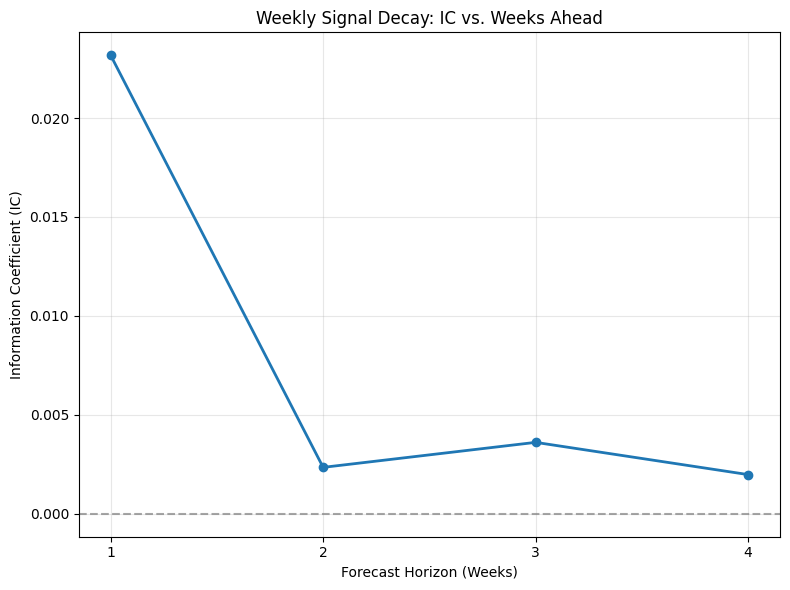

In [313]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import ast

# --------------------------------------------------------------------------------
# CONFIGURATION & PATHS
# --------------------------------------------------------------------------------
SP500_MAPPING = "../data/sp_500_constituents.xlsx"
STOCK_RET_PATH = "momentum/s&p500ret.csv"

# --------------------------------------------------------------------------------
# 1. DATA LOADING HELPER FUNCTIONS
# --------------------------------------------------------------------------------

def load_raw_sentiment() -> pd.DataFrame:
    dfs = []
    for path in SENTIMENT_paths:
        if os.path.exists(path):
            print(f"Loading: {path}")
            dfs.append(pd.read_csv(path))
    
    if not dfs: return pd.DataFrame()
    combined = pd.concat(dfs, ignore_index=True)
    if 'date' in combined.columns:
        combined['date'] = pd.to_datetime(combined['date'])
    return combined

def map_entities_to_tickers(sentiment_df: pd.DataFrame) -> pd.DataFrame:
    if not os.path.exists(SP500_MAPPING):
        return sentiment_df
    sp500 = pd.read_excel(SP500_MAPPING)
    sentiment_df['TICKER'] = sentiment_df['entity'].str.upper()
    valid_tickers = set(sp500['Ticker'].unique())
    return sentiment_df[sentiment_df['TICKER'].isin(valid_tickers)].copy()

def parse_sentiment_string(val):
    if isinstance(val, (int, float)): return val
    if isinstance(val, str):
        try:
            d = ast.literal_eval(val)
            if isinstance(d, dict):
                return d.get('positive', 0) - d.get('negative', 0)
        except: return np.nan
    return np.nan

def build_weekly_signal(daily_df: pd.DataFrame) -> pd.DataFrame:
    daily_df = daily_df.copy()
    daily_df['week_date'] = daily_df['date'].dt.to_period('W-FRI').dt.to_timestamp()
    
    # Detect column
    target_col = next((c for c in ['softmax', 'sentiment', 'score', 'SENT'] if c in daily_df.columns), None)
    if not target_col: return pd.DataFrame()

    # Parse if string
    first_valid = daily_df[target_col].dropna().iloc[0] if not daily_df[target_col].dropna().empty else 0
    if isinstance(first_valid, str) and '{' in first_valid:
        daily_df[target_col] = daily_df[target_col].apply(parse_sentiment_string)
    
    daily_df[target_col] = pd.to_numeric(daily_df[target_col], errors='coerce')
    
    return (daily_df.groupby(['TICKER', 'week_date'])[target_col]
            .mean().reset_index().rename(columns={target_col: 'SENT'}))

def load_stock_returns(csv_path: str) -> pd.DataFrame:
    if not os.path.exists(csv_path): return pd.DataFrame()
    df = pd.read_csv(csv_path)
    df.columns = [c.lower() for c in df.columns]
    df['date'] = pd.to_datetime(df['date'])
    df['ret'] = pd.to_numeric(df['ret'], errors='coerce')
    df = df.dropna(subset=['ret'])
    
    df['week_date'] = df['date'].dt.to_period('W-FRI').dt.to_timestamp()
    weekly_ret = (df.groupby(['ticker', 'week_date'])['ret']
                  .apply(lambda x: (1 + x).prod() - 1)
                  .reset_index().rename(columns={'ret': 'RET', 'ticker': 'TICKER'}))
    weekly_ret['TICKER'] = weekly_ret['TICKER'].str.upper()
    return weekly_ret

# --------------------------------------------------------------------------------
# 2. CORE DECAY ANALYSIS LOGIC
# --------------------------------------------------------------------------------

def compute_future_ic(panel: pd.DataFrame, horizon: int) -> float:
    """
    Computes the average Information Coefficient (IC) for a specific forecast horizon.
    IC = Correlation between Signal(t) and Return(t+horizon)
    """
    shifted = panel.copy()
    # Shift returns backwards by 'horizon' weeks
    # Row T will now contain Signal_T and Return_{T+Horizon}
    shifted['RET_fwd'] = shifted.groupby('TICKER')['RET'].shift(-horizon)
    
    records = []
    # Compute Cross-Sectional Correlation per week
    for date, g in shifted.groupby('week_date'):
        # Need valid signal AND valid future return
        valid_g = g.dropna(subset=['SENT', 'RET_fwd'])
        
        # Need at least 5 tickers to calculate a meaningful correlation
        if len(valid_g) < 5:
            continue
            
        ic = valid_g['SENT'].corr(valid_g['RET_fwd'])
        if pd.notna(ic):
            records.append(ic)
            
    return np.mean(records) if records else np.nan

def run_analysis():
    print("--- Starting Signal Decay Analysis ---")
    
    # 1. Load Data
    raw_sent = load_raw_sentiment()
    if raw_sent.empty: return print("No sentiment data.")
    
    sent_mapped = map_entities_to_tickers(raw_sent)
    weekly_signal = build_weekly_signal(sent_mapped)
    
    weekly_returns = load_stock_returns(STOCK_RET_PATH)
    if weekly_returns.empty: return print("No return data.")

    # 2. Merge Data (Inner Join)
    print(f"Aligning {len(weekly_signal)} signal rows with market data...")
    panel = pd.merge(weekly_signal, weekly_returns, on=['TICKER', 'week_date'], how='inner')
    panel = panel.sort_values(['TICKER', 'week_date'])
    
    if panel.empty: return print("Intersection empty.")

    # 3. Compute Decay
    MAX_HORIZON = 4
    results = []
    print(f"\nComputing IC for horizons 1 to {MAX_HORIZON} weeks...")
    
    for h in range(1, MAX_HORIZON + 1):
        ic = compute_future_ic(panel, h)
        results.append({'horizon': h, 'ic': ic})
        print(f"   Week {h}: IC = {ic:.4f}")

    # 4. Visualize
    df_res = pd.DataFrame(results)
    if not df_res.empty:
        plt.figure(figsize=(8, 6))
        plt.plot(df_res['horizon'], df_res['ic'], marker='o', linewidth=2)
        plt.axhline(0, color='gray', linestyle='--', alpha=0.7)
        plt.title("Weekly Signal Decay: IC vs. Weeks Ahead")
        plt.xlabel("Forecast Horizon (Weeks)")
        plt.ylabel("Information Coefficient (IC)")
        plt.xticks(df_res['horizon'])
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("Could not compute ICs (likely insufficient data points).")

if __name__ == "__main__":
    run_analysis()

In [316]:
########################################
# MONTHLY RETURN TABLE
########################################

weekly_returns = weekly_perf[['week_date', 'port_ret']].rename(columns={'port_ret': 'RET'}) 
if weekly_returns.empty:
    print('No return data available for monthly table.')
else:
    monthly_ret = (
        weekly_returns.assign(month_period=weekly_returns['week_date'].dt.to_period('M'))
                      .groupby('month_period')['RET']
                      .apply(lambda x: (1 + x).prod() - 1)
                      .reset_index()
    )
    monthly_ret['year'] = monthly_ret['month_period'].dt.year
    monthly_ret['month'] = monthly_ret['month_period'].dt.month
    pivot = (
        monthly_ret.pivot(index='year', columns='month', values='RET')
                   .reindex(columns=range(1, 13))
    )
    pivot.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    ytd = (pivot + 1).prod(axis=1, min_count=1) - 1
    pivot['YTD'] = ytd
    monthly_table = pivot.round(4)
    monthly_table.Name = "Monthly Return Table"
    display(monthly_table)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,YTD
year,,,,,,,,,,,,,
2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0176,0.0176
2019,-0.0168,0.0596,0.0047,-0.0097,0.0011,0.0134,0.0507,0.0116,-0.0119,-0.0208,0.0252,0.0228,0.1341
2020,-0.0228,0.1098,-0.0273,0.0367,0.0511,-0.0148,-0.0231,-0.0233,0.0083,-0.0154,0.0082,-0.0165,0.0637
2021,-0.0213,-0.0274,0.0065,0.0258,0.0084,-0.0037,0.0303,0.0219,0.0076,0.0167,0.0141,-0.0305,0.0469
2022,0.0403,0.0561,0.0213,0.0522,0.0160,0.0205,0.0211,0.0351,0.0162,-0.0314,0.0232,0.0099,0.3162
2023,0.0090,0.0465,0.0269,0.0050,0.0185,0.0002,0.0106,0.0283,0.0146,-0.0092,-0.0075,0.0105,0.1632
2024,0.0250,-0.0002,0.0119,-0.0266,0.0160,0.0032,0.0060,0.0255,-0.0123,0.0208,0.0200,0.0227,0.1162


Loading sentiment: ../data/gdelt_scores.csv
Mapped 65036 rows to valid S&P 500 tickers.
Using 'softmax' as the raw sentiment signal.
Parsing stringified dictionaries in column 'softmax'...


/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_31472/2559938121.py:150: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)
/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_31472/2559938121.py:333: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pnl = merged.groupby('week_date').apply(agg_pnl).reset_index()


Loading sentiment: ../data/gnews_scores.csv
Mapped 168172 rows to valid S&P 500 tickers.
Using 'softmax' as the raw sentiment signal.
Parsing stringified dictionaries in column 'softmax'...


/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_31472/2559938121.py:150: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)
/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_31472/2559938121.py:333: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pnl = merged.groupby('week_date').apply(agg_pnl).reset_index()


Loading sentiment: ../data/guardian_scores.csv
Mapped 34228 rows to valid S&P 500 tickers.
Using 'softmax' as the raw sentiment signal.
Parsing stringified dictionaries in column 'softmax'...


/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_31472/2559938121.py:150: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)
/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_31472/2559938121.py:333: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pnl = merged.groupby('week_date').apply(agg_pnl).reset_index()


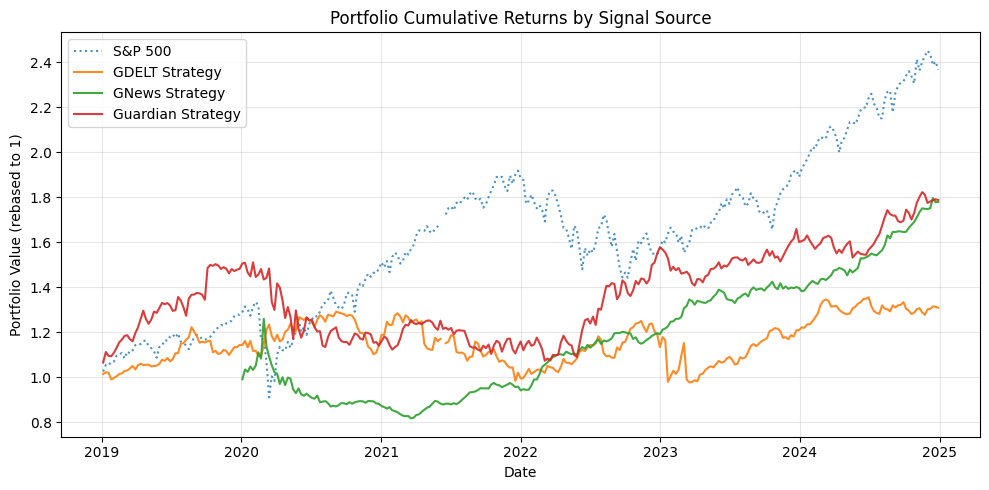

In [187]:
########################################
# MULTI-SIGNAL PORTFOLIO CURVES
########################################

signal_sources = {
    'GDELT Strategy': '../data/gdelt_scores.csv',
    'GNews Strategy': '../data/gnews_scores.csv',
    'Guardian Strategy': '../data/guardian_scores.csv'
}

def run_signal_backtest(label: str, path: str):
    """Run the full pipeline for a single sentiment source and return weekly performance."""
    global SENTIMENT_paths
    prev_paths = list(SENTIMENT_paths)
    try:
        SENTIMENT_paths = [path]
        raw_sent = load_raw_sentiment()
        if raw_sent.empty:
            print(f"[{label}] No sentiment rows.")
            return None
        mapped = map_entities_to_tickers(raw_sent)
        weekly_sig = build_weekly_signal(mapped)
        if weekly_sig.empty:
            print(f"[{label}] No weekly signal after mapping.")
            return None
        weekly_rets = load_stock_returns()
        if weekly_rets.empty:
            print(f"[{label}] No return data.")
            return None
        analysis_df = prepare_aligned_data(weekly_sig, weekly_rets)
        if analysis_df.empty:
            print(f"[{label}] No overlapping rows with returns.")
            return None
        weights = build_weight_panel(
            analysis_df,
            holding_weeks=HOLDING_WEEKS,
            col_signal='SENT',
            equal_weight=equal_weight
        )
        if weights.empty:
            print(f"[{label}] No weights generated.")
            return None
        perf = compute_pnl_timeseries(analysis_df, weights)
        return perf.sort_values('week_date').reset_index(drop=True)
    finally:
        SENTIMENT_paths = prev_paths

portfolio_curves = {}
sp500_curve = None

for label, file_path in signal_sources.items():
    perf = run_signal_backtest(label, file_path)
    if perf is None or perf.empty:
        continue
    series = perf[['week_date', 'port_value']].drop_duplicates('week_date')
    portfolio_curves[label] = series.set_index('week_date')['port_value']
    if sp500_curve is None and 'sp500_value' in perf.columns:
        sp500_curve = (
            perf[['week_date', 'sp500_value']]
            .drop_duplicates('week_date')
            .set_index('week_date')['sp500_value']
        )

if not portfolio_curves:
    print('No portfolio curves available to plot.')
else:
    curves = []
    if sp500_curve is not None:
        curves.append(sp500_curve.rename('S&P 500'))
    curves.extend(series.rename(label) for label, series in portfolio_curves.items())
    plot_df = pd.concat(curves, axis=1).dropna(how='all')
    plot_dates = plot_df.index + pd.Timedelta(weeks=1)

    plt.figure(figsize=(10, 5))
    for col in plot_df.columns:
        linestyle = ':' if col == 'S&P 500' else '-'
        alpha = 0.8 if col == 'S&P 500' else 0.9
        plt.plot(plot_dates, plot_df[col], label=col, linestyle=linestyle, alpha=alpha)

    plt.title('Portfolio Cumulative Returns by Signal Source')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (rebased to 1)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



In [ ]:
########################################
# DAILY REBALANCE BACKTEST
########################################

DAILY_HOLDING_PERIOD = 2
SENTIMENT_paths = ["../data/combined_equal_softmax.csv"] 

def build_daily_signal_frame(daily_df: pd.DataFrame) -> pd.DataFrame:
    if daily_df.empty:
        return pd.DataFrame()
    work = daily_df.copy()
    work['week_date'] = work['date'].dt.floor('D')
    target_col = next((c for c in ['softmax', 'sentiment', 'score', 'SENT'] if c in work.columns), None)
    if target_col is None:
        return pd.DataFrame()
    first_valid = work[target_col].dropna()
    first_val = first_valid.iloc[0] if not first_valid.empty else None
    if isinstance(first_val, str) and '{' in first_val:
        work[target_col] = work[target_col].apply(parse_sentiment_string)
    work[target_col] = pd.to_numeric(work[target_col], errors='coerce')
    return (work.groupby(['TICKER', 'week_date'])[target_col]
                .mean()
                .reset_index()
                .rename(columns={target_col: 'SENT'}))


def load_stock_returns_daily_raw(csv_path: str = STOCK_RET_PATH) -> pd.DataFrame:
    if not os.path.exists(csv_path):
        print(f"Daily return file missing: {csv_path}")
        return pd.DataFrame()
    df = pd.read_csv(csv_path)
    df.columns = [c.lower() for c in df.columns]
    df['date'] = pd.to_datetime(df['date'])
    df['ret'] = pd.to_numeric(df['ret'], errors='coerce')
    df = df.dropna(subset=['ret'])
    df['week_date'] = df['date'].dt.floor('D')
    daily_ret = (df.groupby(['ticker', 'week_date'])['ret']
                   .apply(lambda x: (1 + x).prod() - 1)
                   .reset_index()
                   .rename(columns={'ret': 'RET', 'ticker': 'TICKER'}))
    daily_ret['TICKER'] = daily_ret['TICKER'].str.upper()
    return daily_ret


def prepare_daily_aligned_data(signal_df: pd.DataFrame,
                               returns_df: pd.DataFrame) -> pd.DataFrame:
    # 1) Sort returns and build RET_next on *full* series
    returns_df = returns_df.sort_values(['TICKER', 'week_date'])
    returns_df['RET_next'] = returns_df.groupby('TICKER')['RET'].shift(-1)

    # 2) Drop rows where we don't know the next-day return
    returns_df = returns_df.dropna(subset=['RET_next'])

    # 3) Merge sentiment with returns (now already carrying RET_next)
    panel = signal_df.merge(
        returns_df[['TICKER', 'week_date', 'RET', 'RET_next']],
        on=['TICKER', 'week_date'],
        how='inner'
    )

    # 4)  sort for readability
    panel = panel.sort_values(['TICKER', 'week_date'])

    return panel



def load_sp500_daily_index(csv_path: str = SP500_RET_PATH) -> pd.DataFrame:
    if not os.path.exists(csv_path):
        return pd.DataFrame()
    sp = pd.read_csv(csv_path)
    sp = sp.rename(columns={'caldt': 'date', 'sprtrn': 'sp500_ret'})
    sp['date'] = pd.to_datetime(sp['date'])
    sp['sp500_ret'] = pd.to_numeric(sp['sp500_ret'], errors='coerce')
    sp = sp.dropna(subset=['sp500_ret'])
    sp['week_date'] = sp['date'].dt.floor('D')
    daily = (sp.groupby('week_date')['sp500_ret']
               .apply(lambda x: (1 + x).prod() - 1)
               .reset_index(name='sp500_ret'))
    daily['sp500_ret_next'] = daily['sp500_ret'].shift(-1)
    return daily.dropna(subset=['sp500_ret_next'])


def compute_pnl_timeseries_daily(df: pd.DataFrame,
                                 weight_panel: pd.DataFrame) -> pd.DataFrame:
    merged = pd.merge(
        weight_panel,
        df[['TICKER', 'week_date', 'RET_next']],
        on=['TICKER', 'week_date'],
        how='left'
    )
    merged['pnl'] = merged['weight'] * merged['RET_next']

    def agg_pnl(x):
        long_pnl = x[x['weight'] > 0]['pnl'].sum()
        short_pnl = x[x['weight'] < 0]['pnl'].sum()
        return pd.Series({
            'port_ret_long': long_pnl,
            'port_ret_short': short_pnl,
            'port_ret': long_pnl + short_pnl
        })

    pnl = merged.groupby('week_date').apply(agg_pnl).reset_index()

    benchmark = (
        df.groupby('week_date')['RET_next']
          .mean()
          .rename('benchmark_ret')
          .reset_index()
    )
    pnl = pnl.merge(benchmark, on='week_date', how='left')
    pnl['benchmark_ret'] = pnl['benchmark_ret'].fillna(0.0)
    pnl['excess_ret'] = pnl['port_ret'] - pnl['benchmark_ret']

    sp500 = load_sp500_daily_index()
    if not sp500.empty:
        pnl = pnl.merge(sp500[['week_date', 'sp500_ret_next']], on='week_date', how='left')
        pnl = pnl.rename(columns={'sp500_ret_next': 'sp500_ret'})
        pnl['sp500_ret'] = pnl['sp500_ret'].fillna(0.0)
    else:
        pnl['sp500_ret'] = 0.0

    pnl['port_value'] = (1 + pnl['port_ret']).cumprod()
    pnl['benchmark_value'] = (1 + pnl['benchmark_ret']).cumprod()
    pnl['sp500_value'] = (1 + pnl['sp500_ret']).cumprod()
    pnl['excess_value'] = (1 + pnl['excess_ret']).cumprod()
    return pnl.dropna(subset=['port_ret'])

print("==== DAILY REBALANCE BACKTEST ====")
daily_sent = load_raw_sentiment()

mapped_daily = map_entities_to_tickers(daily_sent)
daily_signal = build_daily_signal_frame(mapped_daily)
daily_returns = load_stock_returns_daily_raw()
daily_panel = prepare_daily_aligned_data(daily_signal, daily_returns)
daily_weights = build_weight_panel(
    daily_panel,
    holding_weeks=DAILY_HOLDING_PERIOD,
    col_signal='SENT',
    equal_weight=equal_weight
)


daily_perf = compute_pnl_timeseries_daily(daily_panel, daily_weights)

weeks = len(daily_perf)
total_ret = daily_perf['port_value'].iloc[-1] - 1
avg = daily_perf['port_ret'].mean()
vol = daily_perf['port_ret'].std(ddof=1)
sharpe = (avg / vol) * np.sqrt(252) if vol > 0 else np.nan

print(f"Total Return: {total_ret:.2%}")
print(f"Daily Sharpe: {sharpe:.2f}")
print(f"Start Date:   {daily_perf['week_date'].min().date()}")
print(f"End Date:     {daily_perf['week_date'].max().date()}")



==== DAILY REBALANCE BACKTEST ====
Loading: ../data/combined_equal_softmax.csv


/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_31472/3595433166.py:31: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


Total Return: 407.86%
Daily Sharpe: 3.35
Start Date:   2019-01-02
End Date:     2024-12-30


/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_31472/3595433166.py:103: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pnl = merged.groupby('week_date').apply(agg_pnl).reset_index()


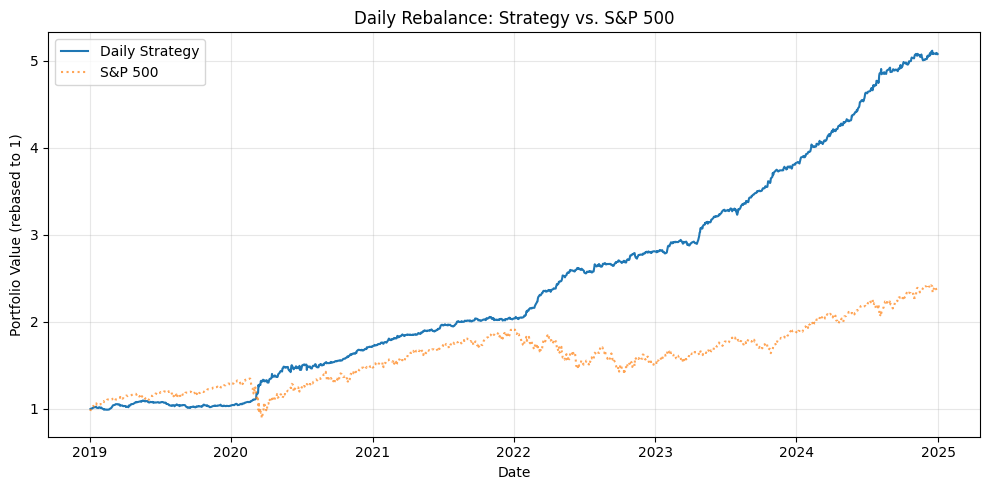

In [281]:
daily_dates = daily_perf['week_date'] + pd.Timedelta(days=1) 
plt.figure(figsize=(10,5))
plt.plot(daily_dates, daily_perf['port_value'], label='Daily Strategy')
plt.plot(daily_dates, daily_perf['sp500_value'], label='S&P 500', linestyle=':', alpha=0.7)
plt.title('Daily Rebalance: Strategy vs. S&P 500')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (rebased to 1)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

(array([  1.,   3.,   7.,  36., 123., 102.,  28.,  10.,   0.,   3.]),
 array([-0.10070716, -0.07983612, -0.05896507, -0.03809402, -0.01722298,
         0.00364807,  0.02451912,  0.04539016,  0.06626121,  0.08713226,
         0.1080033 ]),
 <BarContainer object of 10 artists>)

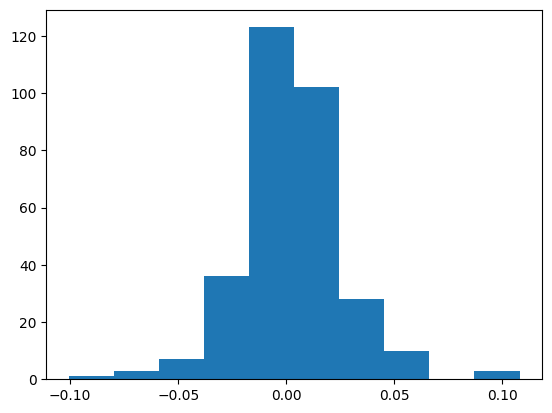

In [204]:
plt.hist(weekly_perf['port_ret'])

(array([  1.,   0.,   4.,  16., 465., 931.,  75.,  11.,   4.,   2.]),
 array([-0.06507183, -0.05224633, -0.03942084, -0.02659534, -0.01376985,
        -0.00094435,  0.01188115,  0.02470664,  0.03753214,  0.05035763,
         0.06318313]),
 <BarContainer object of 10 artists>)

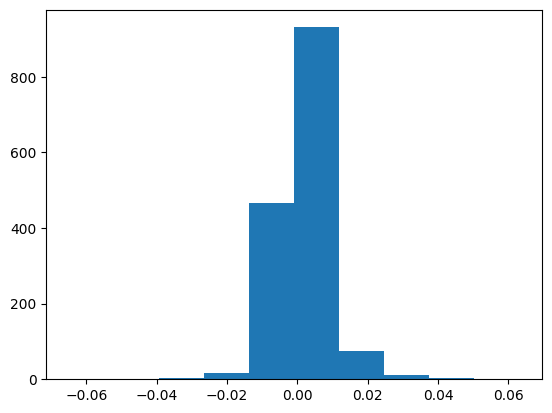

In [266]:
plt.hist(daily_perf['port_ret'])

In [320]:
daily_perf['port_ret'].mean()

np.float64(0.0010907332478186306)

In [216]:
daily_returns

,TICKER,week_date,RET
0,A,2019-01-02,-0.026238
1,A,2019-01-03,-0.036840
2,A,2019-01-04,0.034614
3,A,2019-01-07,0.021234
4,A,2019-01-08,0.014660
...,...,...,...
738221,ZTS,2024-12-24,0.002557
738222,ZTS,2024-12-26,0.004979
738223,ZTS,2024-12-27,-0.005558
738224,ZTS,2024-12-30,-0.014338


In [ ]:
daily_perf['dai']

,week_date,port_ret_long,port_ret_short,port_ret,benchmark_ret,excess_ret,sp500_ret,port_value,benchmark_value,sp500_value,excess_value
0,2019-01-02,-0.009815,0.007768,-0.002046,-0.017867,0.015821,-0.024757,0.997954,0.982133,0.975243,1.015821
1,2019-01-03,0.019764,-0.002475,0.017288,0.020432,-0.003144,0.034336,1.015207,1.002200,1.008729,1.012627
2,2019-01-04,0.008151,-0.007683,0.000468,0.008723,-0.008255,0.007010,1.015682,1.010942,1.015800,1.004268
3,2019-01-07,0.011754,0.002344,0.014098,0.006736,0.007362,0.009695,1.030001,1.017752,1.025648,1.011662
4,2019-01-08,0.008657,0.042212,0.050869,-0.006037,0.056907,0.004098,1.082396,1.011607,1.029851,1.069232
...,...,...,...,...,...,...,...,...,...,...,...
1504,2024-12-23,0.006130,-0.003689,0.002441,0.009158,-0.006717,0.011043,45.983107,2.629647,2.406307,15.285412
1505,2024-12-24,-0.000992,-0.000122,-0.001114,-0.001029,-0.000085,-0.000406,45.931882,2.626940,2.405330,15.284118
1506,2024-12-26,-0.000772,0.002893,0.002122,-0.007961,0.010082,-0.011056,46.029331,2.606028,2.378737,15.438214
1507,2024-12-27,0.000180,0.003964,0.004144,-0.007852,0.011996,-0.010702,46.220096,2.585567,2.353279,15.623412


In [ ]:

########################################
# SENTIMENT DECILE CHARACTERISTICS
########################################

panel = analysis_df[['week_date', 'TICKER', 'SENT', 'RET_next']].dropna().copy()
if panel.empty:
    print('No panel data available for decile analysis.')
else:
    market = load_sp500_weekly()
    if market.empty:
        print('S&P 500 benchmark missing; cannot compute beta or t-stats.')
    else:
        panel = panel.merge(market[['week_date', 'sp500_ret_next']], on='week_date', how='left')
        panel = panel.dropna(subset=['sp500_ret_next'])

        def assign_deciles(group):
            s = group['SENT']
            n = s.notna().sum()
            if n < 10:
                group['decile'] = np.nan
                return group
            ranks = s.rank(method='first')
            try:
                group['decile'] = pd.qcut(ranks, 10, labels=range(1, 11))
            except ValueError:
                group['decile'] = np.nan
            return group

        panel = panel.groupby('week_date', group_keys=False).apply(assign_deciles)
        panel = panel.dropna(subset=['decile'])
        if panel.empty:
            print('Unable to form deciles (insufficient data per week).')
        else:
            panel['decile'] = panel['decile'].astype(int)

            def decile_stats(g):
                n = len(g)
                avg_ret = g['RET_next'].mean()
                avg_mkt = g['sp500_ret_next'].mean()
                beta = np.nan
                if n > 1 and g['sp500_ret_next'].var() > 0:
                    beta = g['RET_next'].cov(g['sp500_ret_next']) / g['sp500_ret_next'].var()
                alpha = np.nan
                if beta == beta:
                    alpha = avg_ret - beta * avg_mkt
                t_val = np.nan
                if n > 1:
                    se = g['RET_next'].std(ddof=1) / np.sqrt(n)
                    if se and se > 0:
                        t_val = avg_ret / se
                return pd.Series({
                    'SENT': g['SENT'].mean(),
                    'Beta': beta,
                    'CAPM Alpha': alpha,
                    'AvgReturn': avg_ret,
                    'AvgReturn T-stat': t_val
                })

            stats = panel.groupby('decile').apply(decile_stats)
            stats = stats.reindex(range(1, 11)).T
            stats.columns = [str(c) for c in range(1, 11)]
            stats['10-1'] = stats['10'] - stats['1']
            stats.loc['AvgReturn T-stat', '10-1'] = np.nan
            display(stats.round(4))



/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_31472/926430691.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  panel = panel.groupby('week_date', group_keys=False).apply(assign_deciles)
/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_31472/926430691.py:60: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats = panel.groupby('decile').apply(decile_stats)


,1,2,3,4,5,6,7,8,9,10,10-1
SENT,-0.5542,-0.1577,-0.0431,-0.0051,0.0071,0.0326,0.0902,0.1920,0.3778,0.7602,1.3144
Beta,0.7475,0.9215,0.7676,0.6885,0.5973,0.6697,0.8200,0.6621,0.6481,0.5303,-0.2172
CAPM Alpha,-0.0005,-0.0005,0.0006,0.0011,0.0007,0.0009,0.0011,0.0014,0.0022,0.0044,0.0049
AvgReturn,0.0018,0.0024,0.0030,0.0032,0.0026,0.0030,0.0037,0.0034,0.0042,0.0061,0.0042
AvgReturn T-stat,2.4260,3.5499,4.7765,5.3058,4.1051,4.6249,5.7674,5.1694,6.2282,8.5512,NaN


In [314]:
########################################
# DAILY SIGNAL IC DECAY
########################################

print("--- Starting Daily Signal Decay Analysis ---")
daily_sent = load_raw_sentiment()
if daily_sent.empty:
    print("No sentiment data.")
else:
    mapped_daily = map_entities_to_tickers(daily_sent)
    daily_signal = mapped_daily.copy()
    daily_signal['week_date'] = daily_signal['date'].dt.floor('D')
    target_col = next((c for c in ['softmax', 'sentiment', 'score', 'SENT'] if c in daily_signal.columns), None)
    if target_col is None:
        print('No sentiment column found for daily IC decay.')
    else:
        first_valid = daily_signal[target_col].dropna()
        first_val = first_valid.iloc[0] if not first_valid.empty else None
        if isinstance(first_val, str) and '{' in first_val:
            daily_signal[target_col] = daily_signal[target_col].apply(parse_sentiment_string)
        daily_signal[target_col] = pd.to_numeric(daily_signal[target_col], errors='coerce')
        daily_signal = (daily_signal.groupby(['TICKER','week_date'])[target_col]
                                     .mean()
                                     .reset_index()
                                     .rename(columns={target_col:'SENT'}))

        daily_returns = load_stock_returns_daily_raw() if 'load_stock_returns_daily_raw' in globals() else load_stock_returns(STOCK_RET_PATH)
        if daily_returns.empty:
            print('No daily return data.')
        else:
            daily_returns = daily_returns.rename(columns={'RET': 'RET_daily'})
            daily_returns['week_date'] = pd.to_datetime(daily_returns['week_date']).dt.floor('D')
            panel = pd.merge(daily_signal, daily_returns, on=['TICKER','week_date'], how='inner')
            panel = panel.sort_values(['TICKER','week_date'])
            if panel.empty:
                print('No overlap between daily signal and returns.')
            else:
                panel['RET_fwd'] = panel.groupby('TICKER')['RET_daily'].shift(-1)
                panel = panel.dropna(subset=['RET_fwd'])
                results = []
                MAX_H = 4
                print(f"Computing daily IC for horizons 1 to {MAX_H} days...")
                for h in range(1, MAX_H+1):
                    shifted = panel.copy()
                    shifted['RET_fwd_h'] = shifted.groupby('TICKER')['RET_daily'].shift(-h)
                    records = []
                    for d, g in shifted.groupby('week_date'):
                        valid = g.dropna(subset=['SENT','RET_fwd_h'])
                        if len(valid) < 5:
                            continue
                        ic = valid['SENT'].corr(valid['RET_fwd_h'])
                        if pd.notna(ic):
                            records.append(ic)
                    ic_mean = np.mean(records) if records else np.nan
                    results.append({'horizon_day': h, 'ic': ic_mean})
                    print(f"   Day {h}: IC = {ic_mean:.4f}")
                df_daily = pd.DataFrame(results)
                if not df_daily.empty:
                    plt.figure(figsize=(8,4))
                    plt.plot(df_daily['horizon_day'], df_daily['ic'], marker='o')
                    plt.axhline(0, color='gray', linestyle='--', alpha=0.7)
                    plt.title('Daily Signal Decay: IC vs Days Ahead')
                    plt.xlabel('Days Ahead')
                    plt.ylabel('Information Coefficient (IC)')
                    plt.grid(True, alpha=0.3)
                    plt.tight_layout()
                    plt.show()
                else:
                    print('Insufficient data to compute daily IC decay.')



--- Starting Daily Signal Decay Analysis ---
Loading: ../data/combined_news_weighted_softmax.csv


/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_31472/2332091640.py:31: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


KeyboardInterrupt: 

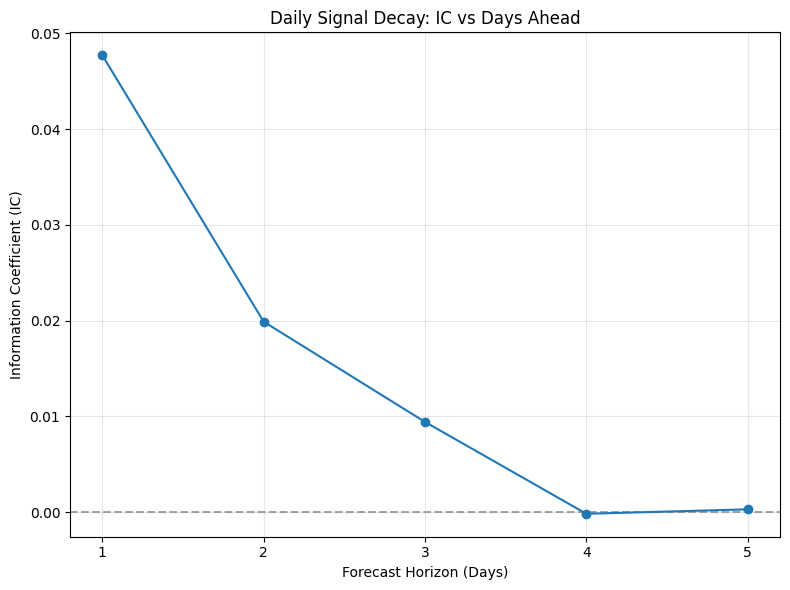

In [315]:
plt.figure(figsize=(8,6))

x = df_daily['horizon_day'].astype(int)
plt.axhline(0, color='gray', linestyle='--', alpha=0.7)
plt.plot(x, df_daily['ic'], marker='o')
plt.title('Daily Signal Decay: IC vs Days Ahead')
plt.xlabel('Forecast Horizon (Days)')
plt.ylabel('Information Coefficient (IC)')
plt.grid(True, alpha=0.3)

plt.xticks(x)          # show 1,2,3,4,5 (no 1.0, 2.0, ...)
plt.tight_layout()
plt.show()


In [319]:

########################################
# DAILY SENTIMENT DECILE CHARACTERISTICS
########################################

if 'daily_panel' not in globals() or daily_panel.empty:
    print('Daily panel not available; run the daily backtest section first.')
else:
    market_daily = load_sp500_daily_index()
    if market_daily.empty:
        print('Daily S&P benchmark missing; cannot compute beta or t-stats.')
    else:
        panel_d = daily_panel[['week_date','TICKER','SENT','RET_next']].dropna().copy()
        panel_d = panel_d.merge(market_daily[['week_date','sp500_ret_next']], on='week_date', how='left')
        panel_d = panel_d.dropna(subset=['sp500_ret_next'])

        def assign_deciles(group):
            s = group['SENT']
            n = s.notna().sum()
            if n < 10:
                group['decile'] = np.nan
                return group
            ranks = s.rank(method='first')
            try:
                group['decile'] = pd.qcut(ranks, 10, labels=range(1, 11))
            except ValueError:
                group['decile'] = np.nan
            return group

        panel_d = panel_d.groupby('week_date', group_keys=False).apply(assign_deciles)
        panel_d = panel_d.dropna(subset=['decile'])
        if panel_d.empty:
            print('Unable to form daily deciles (insufficient data).')
        else:
            panel_d['decile'] = panel_d['decile'].astype(int)

            def decile_stats_daily(g):
                n = len(g)
                avg_ret = g['RET_next'].mean()
                avg_mkt = g['sp500_ret_next'].mean()
                beta = np.nan
                if n > 1 and g['sp500_ret_next'].var() > 0:
                    beta = g['RET_next'].cov(g['sp500_ret_next']) / g['sp500_ret_next'].var()
                alpha = np.nan
                if beta == beta:
                    alpha = avg_ret - beta * avg_mkt
                t_val = np.nan
                if n > 1:
                    se = g['RET_next'].std(ddof=1) / np.sqrt(n)
                    if se and se > 0:
                        t_val = avg_ret / se
                return pd.Series({
                    'SENT': g['SENT'].mean(),
                    'Beta': beta,
                    'CAPM Alpha': alpha,
                    'AvgReturn': avg_ret,
                    'AvgReturn T-stat': t_val
                })

            stats_d = panel_d.groupby('decile').apply(decile_stats_daily)
            stats_d = stats_d.reindex(range(1, 11)).T
            stats_d.columns = [str(c) for c in range(1, 11)]
            stats_d['10-1'] = stats_d['10'] - stats_d['1']
            stats_d.loc['AvgReturn T-stat', '10-1'] = np.nan
            display(stats_d.round(4))



/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_31472/4100830524.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  panel_d = panel_d.groupby('week_date', group_keys=False).apply(assign_deciles)
/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000gn/T/ipykernel_31472/4100830524.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  panel_d = panel_d.groupby('week_date', group_keys=False).apply(assign_deciles)
/var/folders/b7/s8_nr_vd3bvcht_hmrmyy47h0000

,1,2,3,4,5,6,7,8,9,10,10-1
SENT,-0.5903,-0.1760,-0.0456,-0.0081,0.0040,0.0207,0.0623,0.1558,0.3441,0.7465,1.3368
Beta,1.0869,1.0277,0.9947,0.9352,0.9832,0.9415,0.9485,0.9699,0.9544,1.0091,-0.0778
CAPM Alpha,-0.0019,-0.0006,-0.0001,-0.0000,0.0002,-0.0001,-0.0001,0.0003,0.0010,0.0019,0.0037
AvgReturn,-0.0011,0.0001,0.0006,0.0006,0.0009,0.0005,0.0005,0.0010,0.0016,0.0026,0.0037
AvgReturn T-stat,-4.6406,0.4765,3.1042,3.3096,5.1647,2.8139,2.7580,4.8590,7.3780,10.9367,NaN
